## Image Classification: Happy vs Sad Facial Emotions

This model uses Keras on Tensorflow and trains on over 600 images to distinguish between happy (smiling) and sad (frowning)individuals. Images were scraped from Google.

In [3]:
import os

#Dig into directories to put all files in a list
def list_files(path):
    r = []
    for root, dirs, files in os.walk(path):
        for name in files:
            r.append(os.path.join(root, name))
    return r

In [4]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

img_path = './downloads/emotion'

#Get stats about all images we are training and testing on
def get_size_statistics(img_list):
    heights = []
    widths = []
    img_count = 0
    for img in img_list:
        if "DS_Store" not in img:
            try:
                data = np.array(Image.open(img))
                heights.append(data.shape[0])
                widths.append(data.shape[1])
                img_count += 1
            except (IOError, SyntaxError) as e:
                continue
    avg_height = sum(heights) / len(heights)
    avg_width = sum(widths) / len(widths)
    print("Average Height: " + str(avg_height))
    print("Max Height: " + str(max(heights)))
    print("Min Height: " + str(min(heights)))
    print('\n')
    print("Average Width: " + str(avg_width))
    print("Max Width: " + str(max(widths)))
    print("Min Width: " + str(min(widths)))
    print("Total Number of Images: "+ str(img_count))

get_size_statistics(list_files(img_path))

/Users/directioner0829/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2703: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


Average Height: 539.0875912408759
Max Height: 860
Min Height: 348


Average Width: 539.0875912408759
Max Width: 860
Min Width: 348
Total Number of Images: 1233


In [5]:
import cv2 as cv

faceCascade = cv.CascadeClassifier('./assets/haarcascade_frontalface_alt.xml')

#Clean data. Extract faces from photos.
def extract_faces(path):
    output = []
    r = list_files(path)
    for img_file in r:
        if "DS_Store" not in img_file:
            try:
                img_arr = np.array(Image.open(img_file))
                faces = faceCascade.detectMultiScale(img_arr)
                for (x, y, w, h) in faces:
                    face_found = img_arr[y:y + h, x:x + w]
                    img_im = Image.fromarray(face_found, 'RGB')
                    output.append((img_im,img_file))
            except(IOError, SyntaxError, ValueError) as e:
                continue
    return output

In [6]:
#Prepare images for face extraction and labelling

train_faces = extract_faces('downloads/emotion/train')
test_faces = extract_faces('downloads/emotion/test')

In [7]:
labels = [np.array([1,0]), np.array([0, 1])]

#Assigns a label based on which directory the image is in
def label_img(path, labels):
    if 'happy'in path: return labels[0]
    elif 'sad' in path: return labels[1]
    

In [8]:
import PIL

IMG_SIZE = 300

#Label and pack images into lists
def load_data(img_list):
    data = []
    for img_tup in img_list:
        try :
            label = label_img(img_tup[1], labels)
            img_data = img_tup[0].convert('L')
            img_data = img_data.resize((IMG_SIZE, IMG_SIZE), Image.ANTIALIAS)
            data.append([np.array(img_data), label])
        except (IOError, SyntaxError) as e:
            continue
    return data

Number of training images:  1001


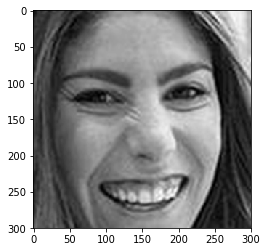

In [9]:
#Load training data

train_data = load_data(train_faces)
print("Number of training images: ", len(train_data))
plt.imshow(train_data[99][0], cmap = 'gist_gray')  

Number of testing images:  125


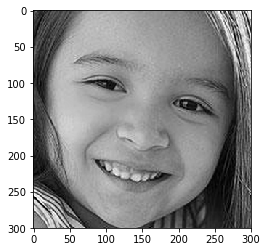

In [11]:
#Load testing Data

test_data = load_data(test_faces)
print("Number of testing images: ", len(test_data))
plt.imshow(test_data[13][0], cmap = 'gist_gray')  

In [ ]:
#Reshapes image to fit given dimensions
def reshape(img):
    return img.reshape(IMG_SIZE, IMG_SIZE, 1)

##Vectorizes data and turn lists into arrays
def vectorize_data_set(data_set, index=0, edit=False):
    output = []
    for element in data_set:
        item = element[index]
        if edit:
            item = reshape(item)
        output.append(item)
    return np.array(output)

In [ ]:
#Vectorize training and testing data

trainImages = vectorize_data_set(train_data, 0, True)
trainLabels = vectorize_data_set(train_data, 1, False)

testImages = vectorize_data_set(test_data, 0, True)
testLabels = vectorize_data_set(test_data, 1, False)

In [ ]:
import keras
from keras import models
from keras import layers
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers. normalization import BatchNormalization

#The Keras model

model = models.Sequential()
model.add(Conv2D(32, kernel_size = (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(96, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(96, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dense(2, activation = 'softmax'))

model.summary()

In [ ]:
from keras_tqdm import TQDMNotebookCallback

#Train the model

model.compile(loss='binary_crossentropy', optimizer='adam', metrics = ['accuracy'])
model.fit(trainImages, trainLabels, batch_size = 50, epochs = 5, verbose = 0, shuffle = True, callbacks=[TQDMNotebookCallback(leave_inner=True, leave_outer=True)])

In [ ]:
## Accuracy of test data on the model

test_loss, test_acc = model.evaluate(testImages, testLabels)
print("Evaluation accuracy",test_acc)

In [ ]:
#Save Model

model.save('./assets/emotion_model')

In [ ]:
#Use model to predict ethnicity of image

def evaluate_img(model, img):
    result = vectorize_data_set([img], 0, True)
    result = model.predict(result, verbose=0)
    if result[0][0] > 0.5:
        print("Guess: Happy with", result[0][0]*100,"% confidence.")
    else:
        print("Guess: Sad with", (1- result[0][0]) * 100 ,"% confidence.")
    plt.imshow(img[0], cmap = 'gist_gray')

In [ ]:
#Predict!

index = 26

evaluate_img(model, test_data[index])